<a href="https://colab.research.google.com/github/SarahGoddaer/Machine_Learning_course_UGent_D012554_kaggle/blob/master/6%3A%20Ensemble%20methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Boosting

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


I will here look at some ensemble methods, beginning with **XGBoost**.

In [2]:
trainset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_train.csv")
testset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_test.csv")

features = trainset.copy()
features.pop('label')
feature_names = list(features.columns)

test_features = testset.copy()
test_features.pop('index')
test_feature_names = list(test_features.columns)
features.describe()

,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,4300.157125,4009.273150,4263.860860,4122.616195,4341.606870,4620.061720,4072.151250,4615.229300,4200.893915,4230.573235,4201.583060,4278.445325,4605.169335,4359.852780
std,36.361719,29.853264,20.788323,20.565528,16.691038,18.034865,20.933632,18.391027,17.810272,19.661149,24.397269,19.645651,33.067591,37.074555
min,4197.950000,3905.640000,4202.560000,4058.460000,4310.260000,4569.740000,4032.820000,4571.280000,4147.690000,4158.970000,4107.180000,4216.410000,4454.360000,4225.640000
25%,4280.510000,3990.770000,4250.260000,4108.720000,4331.790000,4611.790000,4057.440000,4604.100000,4190.260000,4219.490000,4189.740000,4267.180000,4590.642500,4342.050000
50%,4293.330000,4006.150000,4262.560000,4121.030000,4338.460000,4617.950000,4069.740000,4612.820000,4199.490000,4228.720000,4200.000000,4276.410000,4603.080000,4354.360000
75%,4309.740000,4023.590000,4270.260000,4133.460000,4347.180000,4626.150000,4083.590000,4623.080000,4209.230000,4238.970000,4211.280000,4286.150000,4617.950000,4371.790000
max,4497.440000,4152.820000,4385.640000,4234.360000,4452.820000,4754.870000,4174.870000,4731.280000,4315.380000,4352.310000,4325.640000,4397.950000,4796.920000,4538.970000


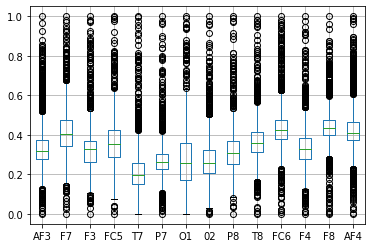

In [0]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)
test_features = scaler.transform(test_features)

features = pd.DataFrame(features, columns=feature_names)
test_features = pd.DataFrame(test_features, columns=test_feature_names)
features.boxplot()

In [0]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(features,trainset.label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
score = cross_val_score(model, features, trainset.label,scoring='roc_auc', cv= 10).mean()
print('AUC score for trainset: '+ str(score))

AUC score for trainset: 0.8777071852714056


On the Kaggle website they say that this should be a very promising model, so I'm going to explore this one for today.

I'll begin again with looking for better parameters:

In [0]:
model.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

The XGBoost model requires parameter tuning to improve and fully leverage its advantages over other algorithms.
The AUC score increased with 5% if I just looked at those two parameters. If I could take this to a higher level, maybe there is a possibility that this could become a very good model.

[This website](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) gives a rigorous explanation about all parameters and how to tune them.

First, I decide *n_estimators* and the *learning-rate*.

In [0]:
estimators = list(range(100,1000,100))
rate = [0.05,0.1,0.2,0.3,0.4]

model = XGBClassifier(max_depth=5, subsample=0.8, colsample_bytree=0.8, gamma=0)
params = dict(n_estimators= estimators, learning_rate=rate)
grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc')
grid_search.fit(features, trainset.label)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)
{'learning_rate': 0.1, 'n_estimators': 400}
0.9326006037824701


Now we have this, I decide what *max_depth* and *min_child_weight* should be according to these results.

In [0]:
depth = list(range(3,10,2))
child = list(range(1,6,2))

model = XGBClassifier(n_estimators=400, subsample=0.8, colsample_bytree=0.8, learning_rate=0.1)
params = dict(max_depth=depth, min_child_weight=child)
grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc')
grid_search.fit(features, trainset.label)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)
{'max_depth': 7, 'min_child_weight': 1}
0.9328682904883238


Now I will refine this:

In [0]:
depth = [5,6,7,8,9]
child = [0,1,2,3]

model = XGBClassifier(n_estimators=400, subsample=0.8, colsample_bytree=0.8, learning_rate=0.1)
params = dict(max_depth=depth, min_child_weight=child)
grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc')
grid_search.fit(features, trainset.label)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=0, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)
{'max_depth': 7, 'min_child_weight': 0}
0.9394627494195722


Knowing this, we can now tune *gamma*:

In [0]:
gammas= [i/10.0 for i in range(0,5)]

model = XGBClassifier(n_estimators=400, max_depth=7, min_child_weight=0, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)
params = dict(gamma=gammas)
grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc')
grid_search.fit(features, trainset.label)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=0, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)
{'gamma': 0.0}
0.9394627494195722


So the default set gamma seems to be the optimal one.

Just checking n_estimators once again now:

In [0]:
estimators = list(range(100,1000,100))

model = XGBClassifier(gamma=0 ,max_depth=7, min_child_weight=0, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)
params = dict(n_estimators= estimators)
grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc')
grid_search.fit(features, trainset.label)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=0, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)
{'n_estimators': 900}
0.9404372534089858


I can refine this number by looking in a smaller range:

In [0]:
estimators = list(range(850,950,10))

model = XGBClassifier(gamma=0 ,max_depth=7, min_child_weight=0, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)
params = dict(n_estimators= estimators)
grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc')
grid_search.fit(features, trainset.label)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=0, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)
{'n_estimators': 900}
0.9404372534089858


In [0]:
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']

for mean_score, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("{:.3f} (+/-{:.3f}) for {}".format(mean_score, std * 2, params))

0.940 (+/-0.031) for {'n_estimators': 850}
0.940 (+/-0.031) for {'n_estimators': 860}
0.940 (+/-0.031) for {'n_estimators': 870}
0.940 (+/-0.031) for {'n_estimators': 880}
0.940 (+/-0.031) for {'n_estimators': 890}
0.940 (+/-0.031) for {'n_estimators': 900}
0.940 (+/-0.031) for {'n_estimators': 910}
0.940 (+/-0.031) for {'n_estimators': 920}
0.940 (+/-0.031) for {'n_estimators': 930}
0.940 (+/-0.031) for {'n_estimators': 940}


Checking *subsample* and *colsample_bytree*:

In [0]:
subsamples = [i/10.0 for i in range(6,10)]
colsamples = [i/10.0 for i in range(6,10)]

model = XGBClassifier(n_estimators=900 ,gamma=0 ,max_depth=7, min_child_weight=0, learning_rate=0.1)
params = dict(subsample= subsamples, colsample_bytree=colsamples)
grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc')
grid_search.fit(features, trainset.label)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'colsample_bytree': 0.9, 'subsample': 0.8}
0.9410687653038368


This gives a lower score so I will try to refine this:

In [0]:
subsamples = [i/100.0 for i in range(75,90,5)]
colsamples = [i/100.0 for i in range(80,95,5)]

model = XGBClassifier(n_estimators=900 ,gamma=0 ,max_depth=7, min_child_weight=0, learning_rate=0.1)
params = dict(subsample= subsamples, colsample_bytree=colsamples)
grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc')
grid_search.fit(features, trainset.label)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'colsample_bytree': 0.9, 'subsample': 0.85}
0.9415581077558297


*reg_alpha* and *reg_lambda* are used to prevent overfitting. I will look for best values for these parameters.

In [0]:
alphas = [1e-5, 1e-2, 0.1, 1, 100]

model = XGBClassifier(n_estimators=900 ,gamma=0 ,max_depth=7, min_child_weight=0, learning_rate=0.1, colsample_bytree=0.8, subsample=0.8)
params = dict(reg_alpha=alphas)
grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc')
grid_search.fit(features, trainset.label)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'reg_alpha': 1e-05}
0.940331192802925


In [0]:
alphas = [1e-5, 0]

model = XGBClassifier(n_estimators=900 ,gamma=0 ,max_depth=7, min_child_weight=0, learning_rate=0.1, colsample_bytree=0.8, subsample=0.8)
params = dict(reg_alpha=alphas)
grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc')
grid_search.fit(features, trainset.label)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'reg_alpha': 0}
0.9404322675020851


In [0]:
model = XGBClassifier(n_estimators= 900, gamma=0 ,max_depth=7, min_child_weight=0, learning_rate=0.1, subsample=0.85, colsample_bytree=0.9)
score = cross_val_score(model, features, trainset.label,scoring='roc_auc', cv= 10).mean()
print('AUC score for trainset: '+ str(score))

AUC score for trainset: 0.9460247876486407


Maybe if I would change pre-processing methods to something else, this score could be elevated.

I'll try some:

In [0]:
trainset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_train.csv")
testset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_test.csv")

features = trainset.copy()
features.pop('label')
feature_names = list(features.columns)

test_features = testset.copy()
test_features.pop('index')
test_feature_names = list(test_features.columns)
features.describe()

,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,4300.157125,4009.273150,4263.860860,4122.616195,4341.606870,4620.061720,4072.151250,4615.229300,4200.893915,4230.573235,4201.583060,4278.445325,4605.169335,4359.852780
std,36.361719,29.853264,20.788323,20.565528,16.691038,18.034865,20.933632,18.391027,17.810272,19.661149,24.397269,19.645651,33.067591,37.074555
min,4197.950000,3905.640000,4202.560000,4058.460000,4310.260000,4569.740000,4032.820000,4571.280000,4147.690000,4158.970000,4107.180000,4216.410000,4454.360000,4225.640000
25%,4280.510000,3990.770000,4250.260000,4108.720000,4331.790000,4611.790000,4057.440000,4604.100000,4190.260000,4219.490000,4189.740000,4267.180000,4590.642500,4342.050000
50%,4293.330000,4006.150000,4262.560000,4121.030000,4338.460000,4617.950000,4069.740000,4612.820000,4199.490000,4228.720000,4200.000000,4276.410000,4603.080000,4354.360000
75%,4309.740000,4023.590000,4270.260000,4133.460000,4347.180000,4626.150000,4083.590000,4623.080000,4209.230000,4238.970000,4211.280000,4286.150000,4617.950000,4371.790000
max,4497.440000,4152.820000,4385.640000,4234.360000,4452.820000,4754.870000,4174.870000,4731.280000,4315.380000,4352.310000,4325.640000,4397.950000,4796.920000,4538.970000


Without scaling:

In [0]:
model = XGBClassifier(n_estimators= 900, gamma=0 ,max_depth=7, min_child_weight=0, learning_rate=0.1, subsample=0.85, colsample_bytree=0.9)
score = cross_val_score(model, features, trainset.label,scoring='roc_auc', cv= 10).mean()
print('AUC score for trainset: '+ str(score))

AUC score for trainset: 0.9460247876486407


With Standard scaling:

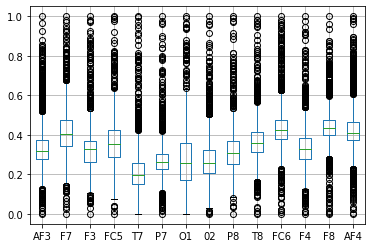

In [0]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)
test_features = scaler.transform(test_features)

features = pd.DataFrame(features, columns=feature_names)
test_features = pd.DataFrame(test_features, columns=test_feature_names)
features.boxplot()

In [0]:
model = XGBClassifier(n_estimators= 900, gamma=0 ,max_depth=7, min_child_weight=0, learning_rate=0.1, subsample=0.85, colsample_bytree=0.9)
score = cross_val_score(model, features, trainset.label,scoring='roc_auc', cv= 10).mean()
print('AUC score for trainset: '+ str(score))

AUC score for trainset: 0.9452571495782506


Despite all this effort, I now read that this model also isn't much dependent on scaling the data, with the same reason as with decision trees and random forests.

This is the last day that I try to better my score..I will use higher cross validation in Gridsearch, in order to artificially enlarge traindata so I could have better fitted parameters to the set.

In [3]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(features,trainset.label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [4]:
score = cross_val_score(model, features, trainset.label,scoring='roc_auc', cv= 10).mean()
print('AUC score for trainset: '+ str(score))

AUC score for trainset: 0.8777071852714056


First checking n_estimators and learning_rate

In [5]:
estimators = list(range(100,1000,100))
rate = [0.05,0.1,0.2,0.3,0.4]

model = XGBClassifier(max_depth=5, subsample=0.8, colsample_bytree=0.8, gamma=0)
params = dict(n_estimators= estimators, learning_rate=rate)
grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc', cv=20)
grid_search.fit(features, trainset.label)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)
{'learning_rate': 0.1, 'n_estimators': 900}
0.9386736202605768


Checking max_depth and min_child_weight

In [6]:
depth = list(range(3,10,2))
child = list(range(1,6,2))

model = XGBClassifier(n_estimators=900, learning_rate=0.1, 
                      subsample=0.8, colsample_bytree=0.8)
params = dict(max_depth=depth, min_child_weight=child)
grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc', cv=20)
grid_search.fit(features, trainset.label)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)
{'max_depth': 7, 'min_child_weight': 1}
0.9389380764163372


Refining this a bit more

In [7]:
depth = [5,6,7,8,9]
child = [0,1,2,3]

model = XGBClassifier(n_estimators=900, learning_rate=0.1, 
                      subsample=0.8, colsample_bytree=0.8)
params = dict(max_depth=depth, min_child_weight=child)
grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc', cv=20)
grid_search.fit(features, trainset.label)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=0, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)
{'max_depth': 8, 'min_child_weight': 0}
0.9456239203630507


Now checking gammas

In [8]:
gammas= [i/10.0 for i in range(0,5)]

model = XGBClassifier(n_estimators=900, max_depth=8, min_child_weight=0, 
                      learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)
params = dict(gamma=gammas)
grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc', cv=20)
grid_search.fit(features, trainset.label)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=0, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)
{'gamma': 0.0}
0.9456239203630507


Checking n_estimators again..

In [9]:
estimators = list(range(100,1000,100))

model = XGBClassifier(gamma=0 ,max_depth=8, min_child_weight=0, 
                      learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)
params = dict(n_estimators= estimators)
grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc', cv=20)
grid_search.fit(features, trainset.label)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=0, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)
{'n_estimators': 900}
0.9456239203630507


Refine by looking at a smaller range:

In [10]:
estimators = list(range(850,950,10))

model = XGBClassifier(gamma=0 ,max_depth=8, min_child_weight=0, 
                      learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)
params = dict(n_estimators= estimators)
grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc', cv=20)
grid_search.fit(features, trainset.label)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=0, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)
{'n_estimators': 900}
0.9456239203630507


Now we're almost done, only subsample and colsample_bytree tuning:

In [12]:
subsamples = [i/10.0 for i in range(6,10)]
colsamples = [i/10.0 for i in range(6,10)]

model = XGBClassifier(n_estimators=900, gamma=0 ,max_depth=8, 
                      min_child_weight=0, learning_rate=0.1)
params = dict(subsample=subsamples, colsample_bytree=colsamples)
grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc', cv=20)
grid_search.fit(features, trainset.label)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=0, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)
{'colsample_bytree': 0.9, 'subsample': 0.6}
0.9462516469038208


Refining the range of these possible parametervalues:

In [13]:
subsamples = [i/100.0 for i in range(60,70,5)]
colsamples = [i/100.0 for i in range(80,95,5)]

model = XGBClassifier(n_estimators=900 ,gamma=0 ,max_depth=8, 
                      min_child_weight=0, learning_rate=0.1)
params = dict(subsample= subsamples, colsample_bytree=colsamples)
grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc')
grid_search.fit(features, trainset.label)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'colsample_bytree': 0.9, 'subsample': 0.65}
0.9410885598587863


I keep subsample= 0.6 because that gave me a better score..
I can try to refine reg_alpha, who knows..

In [14]:
alphas = [1e-5, 1e-2, 0.1, 1, 100]

model = XGBClassifier(n_estimators=900 ,gamma=0 ,max_depth=8, 
                      min_child_weight=0, learning_rate=0.1, 
                      colsample_bytree=0.9, subsample=0.6)
params = dict(reg_alpha=alphas)
grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc', cv=20)
grid_search.fit(features, trainset.label)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=0, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)
{'reg_alpha': 1e-05}
0.9462517932952714


Now this seems to be my slightly better model...

In [16]:
model = XGBClassifier(n_estimators=900, gamma=0, max_depth=8, min_child_weight=0, 
                      learning_rate=0.1, colsample_bytree=0.9, subsample=0.6,
                      reg_alpha=1e-5)
score = cross_val_score(model, features, trainset.label,scoring='roc_auc', cv= 10).mean()
print('AUC score for trainset: '+ str(score))

AUC score for trainset: 0.9468535541930038
